___

<div style="text-align: center;">
  <span style="font-family: 'Playfair Display', serif; font-size: 24px; font-weight: bold;">
Dataset Exploration
  </span>
</div>

___

<p><p>
<div class="alert alert-block alert-info" style="color: #0277BD; background-color: #E1F5FE;">
    

<p>In this notebook, we will explore four datasets stored in DuckDB using PySpark. The datasets include the Criminal Dataset, Airbnb Listings, TripAdvisor Attractions, and Restaurants. The exploration will involve:</p>
<ul>
<li>Identification of Data Quality rules on the datasets</li>
<li>Assessment of the Quality of the Data</li>
<li>Application of Data Cleaning processes (individually per dataset)</li>
<li>Expression of Data quality rules as Denial Constraints</li>
<li>Storage of the improved quality tables in the Trusted Zone, mirroring the tables in the Formatted Zone</li>
</ul>
</div>



In [1]:
#!pip install duckdb
#!pip3 install pyspark
#!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'postgres';"
#!sudo -u postgres psql -U postgres -c 'DROP DATABASE IF EXISTS pyspark_postgres;'
#!sudo -u postgres psql -U postgres -c 'CREATE DATABASE pyspark_postgres;'
#!wget -O "postgresql.jar" "https://repo1.maven.org/maven2/org/postgresql/postgresql/42.7.3/postgresql-42.7.3.jar"
#!wget -O "duckdb.jar" "https://repo1.maven.org/maven2/org/duckdb/duckdb_jdbc/0.10.1/duckdb_jdbc-0.10.1.jar"

In [2]:
## Imports
import duckdb
import pyspark
from pyspark.sql import SparkSession
from pprint import pprint
from pyspark.sql.functions import isnan, when, count, col, regexp_replace, trim
import pandas as pd # -> Visualization
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

## Connection to formatted database
jdbc_url = 'jdbc:duckdb:./../data/formatted_zone/barcelona.db'
driver = "org.duckdb.DuckDBDriver"


# SparkSession inicialitzation
spark = SparkSession.builder\
    .config("spark.jars", "duckdb.jar") \
    .appName("DataExploration") \
    .getOrCreate()


24/04/24 11:09:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


<div style="background-color:#F2F2F2; padding: 10px;">
    <div style="text-align: center;">
  <span style="font-family: 'Playfair Display', serif; font-size: 20px; font-weight: bold;">
     Criminal Dataset
  </span>
</div>

In [3]:
df = spark.read \
  .format("jdbc") \
  .option("url", jdbc_url) \
  .option("driver", driver) \
  .option("query", "SELECT * FROM df_criminal_dataset") \
  .load()

df.limit(2).toPandas() 

,any,n_m_mes,nom_mes,regi_policial_rp,rea_b_sica_policial_abp,prov_ncia,comarca,municipi,tipus_de_lloc_dels_fets,canal_dels_fets,tipus_de_fet,t_tol_del_fet_codi_penal,tipus_de_fet_codi_penal_o,mbit_fet,nombre_fets_o_infraccions,nombre_v_ctimes
0,2021,12,Desembre,RP Metropolitana Nord,ABP Badalona,Barcelona,Barcelonès,Badalona,Via pública urbana,Presencial,Delictes,De les lesions,Lesions,Sexisme,1,1.0
1,2021,6,Juny,RP Central,ABP Anoia,Barcelona,Anoia,Resta municipis ABP Anoia,Habitatge - Escala/portal finca/replà,Presencial,Delictes,Delictes contra la llibertat,Amenaces,Sexisme,1,1.0


### Column names

<div class="alert alert-block alert-info" style="color: #0277BD; background-color: #E1F5FE;">

 - Correct the column names:
      - `n_m_mes` -> `num_mes`
      - `regi_policial_rp` -> `regio_policial`
      - `rea_b_sica_policial_abp` -> `area_basica_policial`
      - `t_tol_del_fet_codi_penal` -> `titol_del_fet_codi_penal`
      - `tipus_de_fet_codi_penal_o` -> `tipus_de_fet_codi_penal`
      - `mbit_fet` -> `ambit_fet`
      - `prov_ncia` -> `provincia`
</div>

In [4]:
# Correct the column names
df = df.withColumnRenamed("n_m_mes", "num_mes") \
       .withColumnRenamed("regi_policial_rp", "regio_policial") \
       .withColumnRenamed("rea_b_sica_policial_abp", "area_basica_policial") \
       .withColumnRenamed("t_tol_del_fet_codi_penal", "titol_del_fet_codi_penal") \
       .withColumnRenamed("tipus_de_fet_codi_penal_o", "tipus_de_fet_codi_penal") \
       .withColumnRenamed("mbit_fet", "ambit_fet") \
       .withColumnRenamed("prov_ncia", "provincia") \
       .withColumnRenamed("nombre_v_ctimes", "nombre_victimes")

### Schema

In [5]:
df.printSchema()

root
 |-- any: decimal(20,0) (nullable = true)
 |-- num_mes: decimal(20,0) (nullable = true)
 |-- nom_mes: string (nullable = true)
 |-- regio_policial: string (nullable = true)
 |-- area_basica_policial: string (nullable = true)
 |-- provincia: string (nullable = true)
 |-- comarca: string (nullable = true)
 |-- municipi: string (nullable = true)
 |-- tipus_de_lloc_dels_fets: string (nullable = true)
 |-- canal_dels_fets: string (nullable = true)
 |-- tipus_de_fet: string (nullable = true)
 |-- titol_del_fet_codi_penal: string (nullable = true)
 |-- tipus_de_fet_codi_penal: string (nullable = true)
 |-- ambit_fet: string (nullable = true)
 |-- nombre_fets_o_infraccions: decimal(20,0) (nullable = true)
 |-- nombre_victimes: double (nullable = true)



<div class="alert alert-block alert-info" style="color: #01571B; background-color: #C8E5C6;">
    
#### DataFrame Schema
- The DataFrame contains various columns representing different aspects of criminal incidents.
- The columns include information such as the year (`any`), month number (`num_mes`), month name (`nom_mes`), police region (`regio_policial`), basic police area (`area_basica_policial`), province (`provincia`), county (`comarca`), municipality (`municipi`), type of location of the events (`tipus_de_lloc_dels_fets`), channel of the events (`canal_dels_fets`), type of crime (`tipus_de_fet`), title of the crime penal code (`titol_del_fet_codi_penal`), crime penal code type (`tipus_de_fet_codi_penal`), crime scope (`ambit_fet`), number of events or infractions (`nombre_fets_o_infraccions`), and number of victims (`nombre_victimes`).
- The data types of the columns include decimal, string, and double, with some columns with null values.

</div>


### Describe

In [6]:
df.describe().toPandas() 

24/04/24 11:09:04 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,summary,any,num_mes,nom_mes,regio_policial,area_basica_policial,provincia,comarca,municipi,tipus_de_lloc_dels_fets,canal_dels_fets,tipus_de_fet,titol_del_fet_codi_penal,tipus_de_fet_codi_penal,ambit_fet,nombre_fets_o_infraccions,nombre_victimes
0,count,2289,2289,2289,2289,2289,2289,2289,2289,2288,2289,2289,2289,2289,2289,2289,863
1,mean,2021.7741,6.7051,None,None,None,None,None,None,None,None,None,None,None,None,1.0000,1.2966396292004636
2,stddev,1.0871606296548673,3.2524835989513767,None,None,None,None,None,None,None,None,None,None,None,None,0.0,0.7321425942635059
3,min,2020,1,Abril,RP Metropolitana Nord,ABP Alt Camp - C. de Barberà,Barcelona,ABP Tarragonès,ABP el Prat de Llobregat,AERO - Altres comerços T1-Arribades,Int. i/o Xarxes,ALTRES,01.-DE L'HOMICIDI I LES SEVES FORMES,Abusos sexuals,Antigitanisme,1,0.0
4,max,2023,12,setembre,RP Terres de l'Ebre,Unitat d'informació RPMB,Tarragona,Vic,Àger,Zona/Eix comercial,Presencial,Infracció administrativa,NORMATIVA ESPORT: DLEG 1/00 I LLEIS 10/90 I 19/07,Violència física o psíquica habitual en l'àmbi...,Ètnic/origen nacional/origen racial,1,7.0


<div class="alert alert-block alert-info" style="color: #01579B; background-color: #E1F5FE; border-color: #01579B;">

#### Summary Observations:
- **Count**: 2289 records for all columns except for "tipus_de_lloc_dels_fets" which has 2288 records.

- The "num_mes" column has a mean value of approximately 6.71, indicating that the data spans multiple months.
- There are 863 records with values in the "nombre_victimes" column, suggesting incidents involving victims.

</div>

### Null Values

In [7]:
# Counting the NaN values
nan_counts = df.select([count(when(isnan(c), c)).alias(c) for c in df.columns])
nan_counts.toPandas()

,any,num_mes,nom_mes,regio_policial,area_basica_policial,provincia,comarca,municipi,tipus_de_lloc_dels_fets,canal_dels_fets,tipus_de_fet,titol_del_fet_codi_penal,tipus_de_fet_codi_penal,ambit_fet,nombre_fets_o_infraccions,nombre_victimes
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<div class="alert alert-block alert-warning" style="color: #C23B22; background-color: #f8c3c0;">

##### NULL VALUES == 0

+ No need to apply changes
</div>


### Filter by region in Barcelona

`[ABP Eixample, ABP Sants-Montjuïc, ABP Les Corts, ABP Horta-Guinardó, ABP Sant Martí, ABP Sarrià-Sant Gervasi, ABP Gràcia, ABP Sant Andreu, ABP Ciutat Vella]`



In [8]:
df.select("area_basica_policial").distinct().show()

+--------------------+
|area_basica_policial|
+--------------------+
|CD Caldes de Montbui|
|ABP Hospitalet de...|
|  ABP Horta-Guinardó|
|        ABP Berguedà|
|       ABP Barcelona|
|       ABP Les Corts|
|   ABP Premià de Mar|
|       ABP Tarragona|
|ABP Sant Feliu de...|
|          ABP Girona|
|   ABP Selva Litoral|
|        ABP Terrassa|
|        ABP Solsonès|
|ABP Sant Boi de L...|
|ABP Sant Vicenç d...|
|         ABP Tortosa|
|Unitat d'informac...|
|           ABP Osona|
|   ABP Pineda de Mar|
|        ABP Vendrell|
+--------------------+
only showing top 20 rows



In [9]:
# Filter by region in Barcelona: [ABP Eixample, ABP Sants-Montjuïc, ABP Les Corts, ABP Barcelona]
df_filtered = df.filter(df["area_basica_policial"].isin("ABP Eixample", "ABP Sants-Montjuïc", "ABP Les Corts", "ABP Horta-Guinardó", 
                                                        "ABP Sant Martí", "ABP Nou Barris", "ABP Sarrià-Sant Gervasi","ABP Gràcia", "ABP Sant Andreu", "ABP CIUTAT VELLA", "ABP Ciutat Vella"))

df_filtered = df_filtered.withColumn("area_basica_policial", regexp_replace("area_basica_policial", "^ABP ", ""))
df_filtered.limit(4).toPandas()

,any,num_mes,nom_mes,regio_policial,area_basica_policial,provincia,comarca,municipi,tipus_de_lloc_dels_fets,canal_dels_fets,tipus_de_fet,titol_del_fet_codi_penal,tipus_de_fet_codi_penal,ambit_fet,nombre_fets_o_infraccions,nombre_victimes
0,2021,6,Juny,RP Metropolitana Barcelona,Nou Barris,Barcelona,Barcelonès,Barcelona,Via pública urbana,Presencial,Delictes,Delictes contra la llibertat,Amenaces,Orientació política,1,1.0
1,2020,1,Gener,RP Metropolitana Barcelona,Eixample,Barcelona,Barcelonès,Barcelona,Zona d'oci/lúdica,Presencial,Delictes,Delictes contra el patrimoni i contra l’ordre ...,Robatori amb violència i/o intimidació,LGTBI-fòbia,1,1.0
2,2020,1,Gener,RP Metropolitana Barcelona,Sant Andreu,Barcelona,Barcelonès,Barcelona,Via pública urbana,Presencial,Delictes,Delictes contra la Constitució,Contra exercici drets fonamentals i llibertats...,"Ètnic, origen nacional i/o racial",1,2.0
3,2020,1,Gener,RP Metropolitana Barcelona,Sants-Montjuïc,Barcelona,Barcelonès,Barcelona,Transport públic - Renfe - Adif - Estació,Presencial,Delictes,De les lesions,Lesions,"Ètnic, origen nacional i/o racial",1,1.0


In [10]:
df_filtered.limit(2).toPandas() 

,any,num_mes,nom_mes,regio_policial,area_basica_policial,provincia,comarca,municipi,tipus_de_lloc_dels_fets,canal_dels_fets,tipus_de_fet,titol_del_fet_codi_penal,tipus_de_fet_codi_penal,ambit_fet,nombre_fets_o_infraccions,nombre_victimes
0,2021,6,Juny,RP Metropolitana Barcelona,Nou Barris,Barcelona,Barcelonès,Barcelona,Via pública urbana,Presencial,Delictes,Delictes contra la llibertat,Amenaces,Orientació política,1,1.0
1,2020,1,Gener,RP Metropolitana Barcelona,Eixample,Barcelona,Barcelonès,Barcelona,Zona d'oci/lúdica,Presencial,Delictes,Delictes contra el patrimoni i contra l’ordre ...,Robatori amb violència i/o intimidació,LGTBI-fòbia,1,1.0



### Remove redundant columns

<div class="alert alert-block alert-warning" style="color: #FFB300; background-color: #FFF9C4;">

<p>In this step, we remove the redundant columns from the DataFrame that are not of interest for our analysis. These columns include "provincia", "comarca", "municipio", and "regio_policial".  All the regions, provinces, and comarcas are located within Barcelona.</p>
</div>



In [11]:
columns_to_drop = ["provincia", "comarca", "municipi", "regio_policial"]
df_filtered = df_filtered.drop(*columns_to_drop)

In [12]:
df_filtered.limit(2).toPandas()

,any,num_mes,nom_mes,area_basica_policial,tipus_de_lloc_dels_fets,canal_dels_fets,tipus_de_fet,titol_del_fet_codi_penal,tipus_de_fet_codi_penal,ambit_fet,nombre_fets_o_infraccions,nombre_victimes
0,2021,6,Juny,Nou Barris,Via pública urbana,Presencial,Delictes,Delictes contra la llibertat,Amenaces,Orientació política,1,1.0
1,2020,1,Gener,Eixample,Zona d'oci/lúdica,Presencial,Delictes,Delictes contra el patrimoni i contra l’ordre ...,Robatori amb violència i/o intimidació,LGTBI-fòbia,1,1.0


<div class="alert alert-block alert-info" style="color: #01579B; background-color: #E1F5FE; border-color: #01579B;">

#### Numeric Features Distributions Insights:
- Feature `nombre_fets_o_infraccions` -> All the values concentrated in 1 --> Redudant Col --> Drop
- None values in feature `nombre_victimes` -> Replace each None value with 0
- More criminality acts in 2023
- In summer and Spring (May and July) is the month with more criminal acts
  in Barcelona and December the least.
  - We'll keep both the `num_mes` and `nom_mes` variables for visualization purposes.
- Most criminal cases have  1 victim and a maximum of 7 victims with a low concentration.

</div>

In [13]:
# Replace each None -> 1 victims (minimum per dencuncia)
df_filtered = df_filtered.withColumn('nombre_victimes', when(col('nombre_victimes').isNull(), 1).otherwise(col('nombre_victimes')))

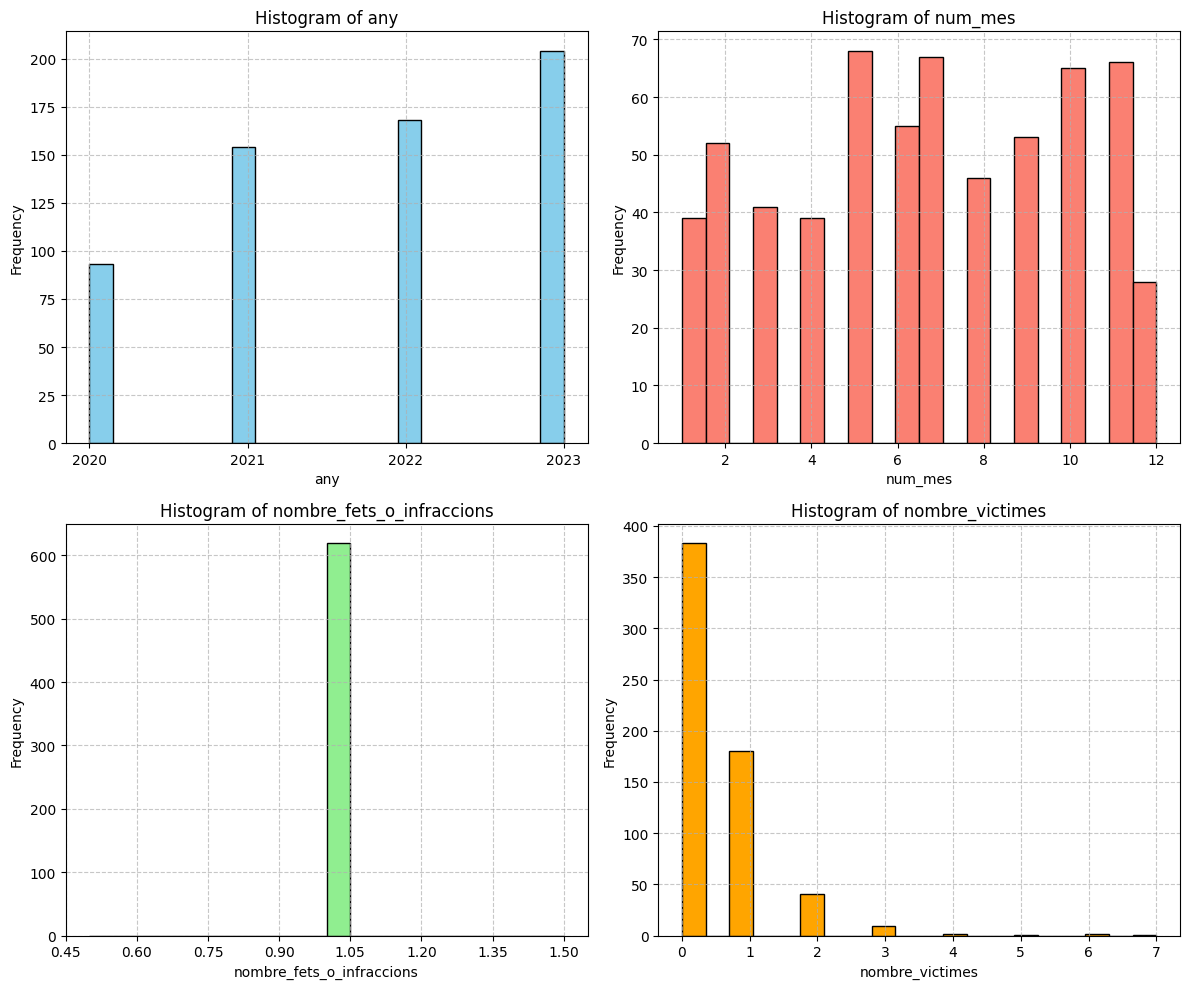

In [14]:
def plot_numeric_histograms(df):
    numeric_columns = ['any', 'num_mes', 'nombre_fets_o_infraccions', 'nombre_victimes']
    colors = ['skyblue', 'salmon', 'lightgreen', 'orange']
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))  
    axs = axs.flatten()  
    
    for i, column in enumerate(numeric_columns):
        column_data = df.select(column).rdd.flatMap(lambda x: x).collect()
        '''
        # nombre_victimes --> None values
        for x in column_data:
            if x == None:
                print(column)
                print(x)
        '''
        #column_data = [int(x) for x in column_data if x is not None]

        if column_data:
            ax = axs[i] 
            frequencies, bins, _ = ax.hist(column_data, bins=20, color=colors[i], edgecolor='black')
            ax.set_title(f'Histogram of {column}')
            ax.set_xlabel(column)
            ax.set_ylabel('Frequency')
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True)) 
    
    plt.tight_layout()
    plt.show()


plot_numeric_histograms(df_filtered)

In [15]:
# Remove redundant col --> nombre_fets_o_infraccions
df_filtered = df_filtered.drop('nombre_fets_o_infraccions')

<div class="alert alert-block alert-info" style="color: #01579B; background-color: #E1F5FE; border-color: #01579B;">

#### Categorical Features Distributions Insights:
+ Examining the `"area_basica_policial"` variable reveals technical data cleaning improvements where the `"Ciutat Vella"` basic police area is inconsistently spelled in uppercase and lowercase → unify.
- Interestingly, `"Eixample"` and `"Ciutat Vella"` are the regions where hate crimes occur most frequently.
- The `"tipus_de_fet"` variable indicates that the majority of incidents are crimes, but the variable itself is redundant for our study → drop.
- The `"ambit_fet"` feature indicates the type of crime, with hate crimes based on LGTBI-fobia standing out significantly with a much higher ratio than others.
- The `"canal_dels_fets"` variable indicates whether incidents were reported through social channels or in person. Since our study focuses on street incidents in Barcelona, non-face-to-face criminal acts will not be considered.

</div>

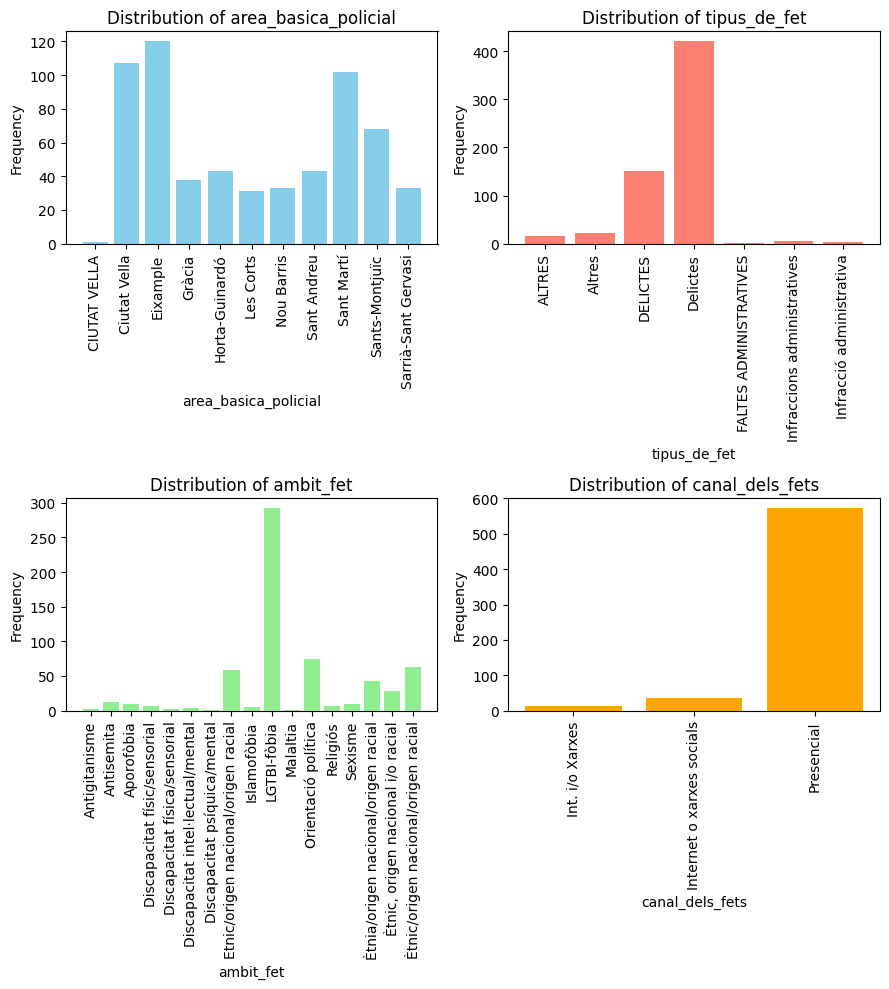

In [16]:
def plot_categorical_distribution(df, column, ax, color):
    counts = df.groupBy(column).count().orderBy(column).collect()
    labels = [row[column] for row in counts]
    frequencies = [row['count'] for row in counts]
    ax.bar(labels, frequencies, color=color)
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {column}')
    ax.tick_params(axis='x', rotation=90)

# Categorical features 
categorical_columns = ['area_basica_policial', 'tipus_de_fet', 'ambit_fet', 'canal_dels_fets']

fig, axs = plt.subplots(2, 2, figsize=(9, 10))  
axs = axs.flatten()  # Aplanar la matriz de subplots
color_palette = ['skyblue', 'salmon', 'lightgreen', 'orange'] # Paleta de colores

for i, column in enumerate(categorical_columns):
    ax = axs[i]  
    color = color_palette[i % len(color_palette)]  
    plot_categorical_distribution(df_filtered, column, ax, color)

plt.tight_layout()
plt.show()

In [17]:
# CATEGORIC DATA CLEANING
# Replace Ciutat Vella uppercase
df_filtered = df_filtered.withColumn("area_basica_policial", 
                                     regexp_replace(df_filtered["area_basica_policial"], 
                                      "CIUTAT VELLA",   "Ciutat Vella"))

df_filtered = df_filtered.drop('tipus_de_fet')

# Filter the data to keep only the values where canals_dels_fets == "Presencial"
df_filtered = df_filtered.filter(df_filtered["canal_dels_fets"] == "Presencial")

# Drop canals_dels_fets --> Redundant
df_filtered = df_filtered.drop('canal_dels_fets')


<div class="alert alert-block alert-info" style="color: #01579B; background-color: #E1F5FE; border-color: #01579B;">

#### Textual Features  Insights -- Word Cloud

+ The variable `titol_de_fet_codi_penal` is not relevant for visualizing the results for our study -- Legislative
+ `Tipus de codi penal` requires preprocessing before the variable can be useful for the study
+ `Tipus de lloc dels fets`clearly highlights that the majority of crimes occur in public places, also inside residential premises (apartments, houses), as well as in building entrances or public transport.

</div>


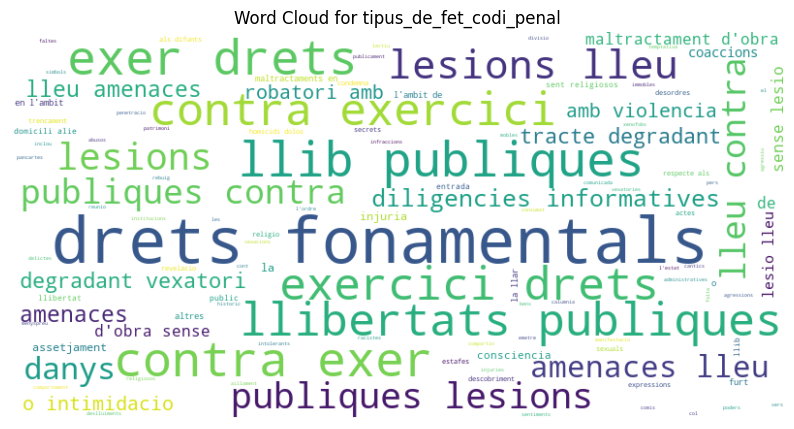

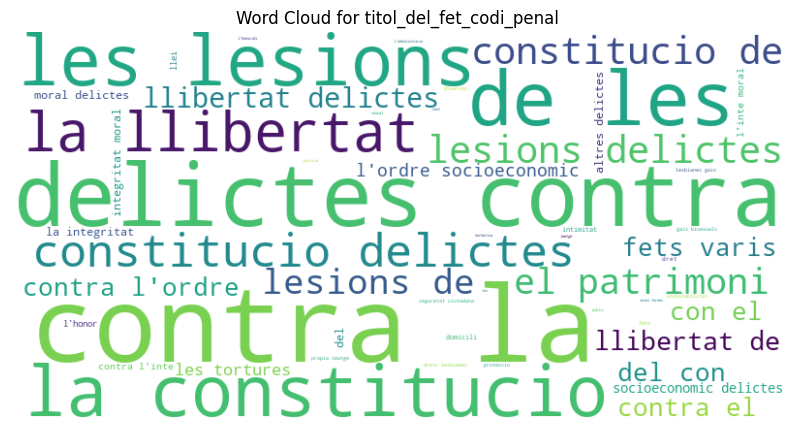

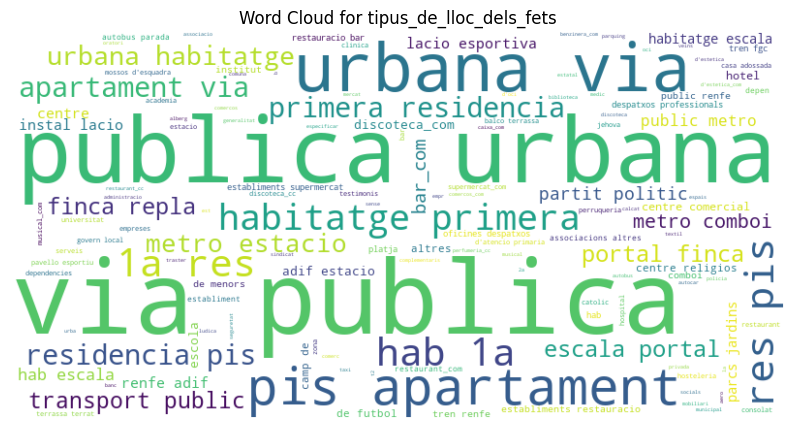

In [18]:
from wordcloud import WordCloud
from unidecode import unidecode

def generate_word_cloud(values, title):
    text = " ".join(unidecode(value).lower() for value in values) # Unifquem en minuscuels y sense accents x treure + insides
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Textual cols
columns_and_titles = {
    "tipus_de_fet_codi_penal": "Word Cloud for tipus_de_fet_codi_penal",
    "titol_del_fet_codi_penal": "Word Cloud for titol_del_fet_codi_penal",
    "tipus_de_lloc_dels_fets": "Word Cloud for tipus_de_lloc_dels_fets"
}

for column, title in columns_and_titles.items():
    values = df_filtered.select(column).rdd.flatMap(lambda x: x).filter(lambda x: x is not None).collect()
    generate_word_cloud(values, title)


In [19]:
# Remove redundant col --> nombre_fets_o_infraccions
df_filtered = df_filtered.drop('titol_del_fet_codi_penal')

In [20]:
# Preprocessing --> tipus_de_lloc_dels_fets
tipus_de_lloc_dels_fets_values = df_filtered.select("tipus_de_lloc_dels_fets").rdd.flatMap(lambda x: x).filter(lambda x: x is  None).collect()
tipus_de_lloc_dels_fets_values # Nomes hi ha un none drop la mostra

[None]

In [21]:
df_filtered = df_filtered.filter(df_filtered.tipus_de_lloc_dels_fets.isNotNull())

In [45]:
df_filtered.limit(2).toPandas() 

,any,num_mes,nom_mes,neighbourhood,tipus_de_lloc_dels_fets,tipus_de_fet_codi_penal,ambit_fet,nombre_victimes
0,2021,6,Juny,Nou Barris,Via pública urbana,Amenaces,Orientació política,1.0
1,2020,1,Gener,Eixample,Zona d'oci/lúdica,Robatori amb violència i/o intimidació,LGTBI-fòbia,1.0
2,2020,1,Gener,Sant Andreu,Via pública urbana,Contra exercici drets fonamentals i llibertats...,"Ètnic, origen nacional i/o racial",2.0
3,2020,1,Gener,Sants-Montjuïc,Transport públic - Renfe - Adif - Estació,Lesions,"Ètnic, origen nacional i/o racial",1.0
4,2020,1,Gener,Eixample,Via pública urbana,Contra exercici drets fonamentals i llibertats...,LGTBI-fòbia,1.0
...,...,...,...,...,...,...,...,...
566,2023,12,desembre,Gràcia,Hab. 1a Res. Pis/apartament,Lesions (lleu),LGTBI-fòbia,0.0
567,2023,12,desembre,Gràcia,Via Pública urbana,Contra exer. drets fonamentals i llib. públiques,Discapacitat intel·lectual/mental,0.0
568,2023,12,desembre,Ciutat Vella,Hab. 1a Res. Pis/apartament,Lesions (lleu),LGTBI-fòbia,0.0
569,2023,12,desembre,Eixample,Depen. Govern Local,Contra exer. drets fonamentals i llib. públiques,LGTBI-fòbia,0.0


<div style="background-color:#F2F2F2; padding: 10px;">
    <div style="text-align: center;">
  <span style="font-family: 'Playfair Display', serif; font-size: 20px; font-weight: bold;">
     Airbnb Dataset
  </span>
</div>

In [36]:
df_aribnb = spark.read \
  .format("jdbc") \
  .option("url", jdbc_url) \
  .option("driver", driver) \
  .option("query", "SELECT * FROM df_airbnb_listings") \
  .load()

df_aribnb.limit(4).toPandas()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,jurisdiction_names,cancellation_policy,calculated_host_listings_count,reviews_per_month,features,geolocation.lon,geolocation.lat,__index_level_0__
0,14618223,https://www.airbnb.com/rooms/14618223,20170407214050,2017-04-08,Piso cerca del Cam Nou,Acogedor y juvenil piso bien comunicado y en u...,Somos 2 chicos jóvenes y trabajadores que segu...,Acogedor y juvenil piso bien comunicado y en u...,none,None,El precio publicado es por habitacion,Tenemos a 3' las lineas 5 de metro (conectada ...,"Tendrás acceso a la cocina, baño y zonas comunes",None,None,None,None,NaN,None,38925857,https://www.airbnb.com/users/show/38925857,Javier,2015-07-19,"Toledo, Castile-La Mancha, Spain","Muy aficionado al deporte, practico casi cualq...",within a day,60.0,NaN,https://a0.muscache.com/im/pictures/c4b46d10-2...,https://a0.muscache.com/im/pictures/c4b46d10-2...,None,1.0,1.0,"email, phone, reviews, jumio","Barcelona, CT 08028, Spain",None,la Maternitat i Sant Ramon,Les Corts,Barcelona,CT,08028,Barcelona,"Barcelona, Spain",ES,Spain,41.378150177192396,2.122075545481956,Apartment,Private room,2,2.0,1.0,2.0,Real Bed,"TV, Internet, Wireless Internet, Kitchen, Elev...",None,21.0,NaN,NaN,NaN,NaN,1,7,1,1125,yesterday,NaN,0,4,34,309,2017-04-07,1,2016-08-22,2016-08-22,100.0,10.0,10.0,10.0,10.0,10.0,10.0,None,NaN,moderate,1,0.13,"Host Has Profile Pic, Host Identity Verified, ...",2.122076,41.378150,0
1,476120,https://www.airbnb.com/rooms/476120,20170407214050,2017-04-08,Room @ Villa w/ beautiful garden.,Spacious room with much ligth and views with p...,Villa Maria was built for a famous Catalan ope...,Spacious room with much ligth and views with p...,none,Situated in a quiet neighborhood with all amen...,The Villa is located in the Collserola mountai...,Public transport is (literally) next to the ho...,"Kitchen, bathroom (with bath), washing machine...","We are a small community of six people, we spe...",The house is space free of shoes. Guests shoul...,None,None,NaN,None,1344607,https://www.airbnb.com/users/show/1344607,Alexis,2011-10-28,"Barcelona, Cataluña, Spain",Social entrepreneurs living in Barcelona.,a few days or more,0.0,NaN,https://a0.muscache.com/im/pictures/bb3c1d98-d...,https://a0.muscache.com/im/pictures/bb3c1d98-d...,Sarrià,1.0,1.0,"email, phone, reviews, jumio, work_email","Sarrià, Barcelona, Catalonia 08017, Spain",Sarrià,"Vallvidrera, el Tibidabo i les Planes",Sarrià-Sant Gervasi,Barcelona,Catalonia,08017,Barcelona,"Barcelona, Spain",ES,Spain,41.4148655885311,2.1049250609405097,Villa,Private room,2,1.0,1.0,1.0,Real Bed,"TV, Internet, Wireless Internet, Kitchen, Free...",3014,37.0,300.0,950.0,650.0,60.0,1,15,30,180,3 weeks ago,NaN,30,60,90,365,2017-04-08,39,2012-06-09,2016-08-07,94.0,9.0,9.0,10.0,10.0,9.0,9.0,None,NaN,strict,1,0.66,"Host Has Profile Pic, Host Identity Verified, ...",2.104925,41.414866,1
2,54173


### Remove redundant columns

<div class="alert alert-block alert-warning" style="color: #FFB300; background-color: #FFF9C4;">

+ All records with broken links --> Drop
+ Perform extensive cleaning to remove redundant columns from the DataFrame that are not relevant for our analysis.
+ Summary == Description (same feature)


</div>



In [38]:
pd.set_option('display.max_columns', None)

columns_to_drop = ["id","listing_url", "Description", "experiences_offered", "scrape_id", "last_scraped", "jurisdiction_names", "thumbnail_url", "host_acceptance_rate", "host_thumbnail_url", "host_picture_url", "xl_picture_url","picture_url", "host_thumbnail_url", "host_neighbourhood", "host_url", "medium_url", "host_listings_count", "host_total_listings_count",  "__index_level_0__", "state", "license", "calendar_last_scraped", "calculated_host_listings_count", "first_review", "last_review", "has_availability", "calendar_updated"]
df_aribnb = df_aribnb.drop(*columns_to_drop)

#df_aribnb.limit(4).toPandas()


    
#### Location Features Unification


<div class="alert alert-block alert-warning" style="color: #FFB300; background-color: #FFF9C4;">
- All the apartments are located in Barcelona -> Remove the redundant cols in location stage that are the same
    - `['market', "city", "smart_location", "country", "country_code", "zipcode", ]
- `Market` feature -> Outliers that are not in barcelona --> Drop
- `Latitud`, `Longitud`, `geolocation.lon`, `geolocation.lat`
    - Are the same values?
- Relation data `neighbourhood` features & `criminal_dataset`
</div>

In [26]:
# Data Cleaning - Remove all the instance that the market is not Barcelona
df_aribnb.select("market").distinct().show()
df_aribnb = df_aribnb.filter(df_aribnb['market'] == 'Barcelona')

+----------------+
|          market|
+----------------+
|       Barcelona|
|    Buenos Aires|
|Costa Brava Nord|
|        Valencia|
|            NULL|
+----------------+



In [39]:
# Contry and city feature == same Barcelona and Spain -- Redudant 
# Zip code -- We have te gelocation data -- Redundant
df_aribnb.select("city").distinct().show()
df_aribnb.select("smart_location").distinct().show()
#df_aribnb.select("zipcode").distinct().show()
df_aribnb.select("country").distinct().show()
df_aribnb.select("country_code").distinct().show()

columns_to_drop = ["city", "zipcode", "smart_location", "country", "country_code", "market" ]
df_aribnb = df_aribnb.drop(*columns_to_drop)


+---------+
|     city|
+---------+
|Barcelona|
|barcelona|
+---------+

+-----------------+
|   smart_location|
+-----------------+
|Barcelona , Spain|
| barcelona, Spain|
| Barcelona, Spain|
|barcelona , Spain|
+-----------------+

+-------+
|country|
+-------+
|  Spain|
+-------+

+------------+
|country_code|
+------------+
|          ES|
+------------+



In [40]:
# Location change name -- solving text issues
column_mapping = dict(zip(df_aribnb.columns[-2:], ["geolocation_lon", "geolocation_lat"]))

for old_name, new_name in column_mapping.items():
    df_aribnb = df_aribnb.withColumnRenamed(old_name, new_name)


location = df_aribnb.select("geolocation_lon", "geolocation_lat", "latitude", "longitude").limit(5)
location.show()

# Same values -- Drop geolocation_lon and geolocation_lon
columns_to_drop = ["geolocation_lon", "geolocation_lat"]
df_aribnb = df_aribnb.drop(*columns_to_drop)

+------------------+------------------+------------------+------------------+
|   geolocation_lon|   geolocation_lat|          latitude|         longitude|
+------------------+------------------+------------------+------------------+
| 2.122075545481956|41.378150177192396|41.378150177192396| 2.122075545481956|
|2.1049250609405097|  41.4148655885311|  41.4148655885311|2.1049250609405097|
|2.1407658129075626|41.410925919974986|41.410925919974986|2.1407658129075626|
|2.1578867703448044| 41.40097836628479| 41.40097836628479|2.1578867703448044|
| 2.208579360995987| 41.42119449770243| 41.42119449770243| 2.208579360995987|
+------------------+------------------+------------------+------------------+



In [41]:
# Same data information -- MOST RELEVANT neighbourhood_group_cleansed == area_basica_policial (criminal dataset) 
df_aribnb.select("neighbourhood_cleansed").distinct().show()
df_aribnb.select("neighbourhood_group_cleansed").distinct().show()
df_aribnb.select("neighbourhood").distinct().show()

# Same values -- Drop geolocation_lon and geolocation_lon
columns_to_drop = ["neighbourhood_cleansed", "neighbourhood"]
df_aribnb = df_aribnb.drop(*columns_to_drop)

+----------------------+
|neighbourhood_cleansed|
+----------------------+
|           el Poblenou|
|     la Vila de Gràcia|
|  el Besòs i el Mar...|
|          la Guineueta|
|          la Teixonera|
|  la Dreta de l'Eix...|
|           el Guinardó|
|        el Barri Gòtic|
|              Vallbona|
|             Canyelles|
|  Provençals del Po...|
|   la Verneda i la Pau|
|  Vilapicina i la T...|
|  l'Antiga Esquerra...|
|                 Navas|
|     la Marina de Port|
|                Sarrià|
|  la Marina del Pra...|
|            Torre Baró|
|      la Trinitat Nova|
+----------------------+
only showing top 20 rows

+----------------------------+
|neighbourhood_group_cleansed|
+----------------------------+
|                      Gràcia|
|                  Sant Martí|
|              Horta-Guinardó|
|                   Les Corts|
|              Sants-Montjuïc|
|                  Nou Barris|
|         Sarrià-Sant Gervasi|
|                    Eixample|
|                 Sant Andreu|
| 

In [42]:
# Same Name -- Relation -- Same col names 
df_aribnb = df_aribnb.withColumnRenamed("neighbourhood_group_cleansed", "neighbourhood")
df_filtered = df_filtered.withColumnRenamed("area_basica_policial", "neighbourhood")
df_aribnb.select("neighbourhood").distinct().show()
df_filtered.select("neighbourhood").distinct().show()

+-------------------+
|      neighbourhood|
+-------------------+
|             Gràcia|
|         Sant Martí|
|     Horta-Guinardó|
|          Les Corts|
|     Sants-Montjuïc|
|         Nou Barris|
|Sarrià-Sant Gervasi|
|           Eixample|
|        Sant Andreu|
|       Ciutat Vella|
+-------------------+

+-------------------+
|      neighbourhood|
+-------------------+
|             Gràcia|
|         Sant Martí|
|     Horta-Guinardó|
|          Les Corts|
|     Sants-Montjuïc|
|         Nou Barris|
|Sarrià-Sant Gervasi|
|           Eixample|
|        Sant Andreu|
|       Ciutat Vella|
+-------------------+



<div class="alert alert-block alert-info" style="color: #01571B; background-color: #C8E5C6;">
    
#### DataFrame Schema selected for the project


The DataFrame comprises various groups of columns, each providing distinct details related to property listings:

- The DataFrame has **9999 rows** and **54 columns**.

**Property Information:**
- **name:** A string indicating the name of the property.
- **summary:** A string providing a brief overview of the property.
- **space:** A string describing the available space within the property.
- **neighborhood_overview:** A string offering insights into the neighborhood surrounding the property.
- **notes:** Additional notes or remarks about the property.

**Host Information:**
- **host_id:** An identifier for the host of the property.
- **host_name:** The name of the host.
- **host_since:** The date when the host joined the platform.
- **host_location:** The location of the host.
- **host_about:** Information or description about the host.

**Host Response Details:**
- **host_response_time:** The typical response time of the host.
- **host_response_rate:** The rate of responses from the host, represented as a double.
- **host_verifications:** Methods used to verify the host's identity.

**Location Details:**
- **street:** The street address of the property.
- **neighbourhood:** The name of the neighborhood where the property is located.
- **latitude:** The latitude coordinate of the property.
- **longitude:** The longitude coordinate of the property.

**Property Details:**
- **property_type:** The type or category of the property.
- **room_type:** The type of room available in the property (e.g., entire home, private room, shared room).
- **accommodates:** The maximum number of guests the property can accommodate, represented as a decimal.
- **bathrooms:** The number of bathrooms in the property, represented as a double.
- **bedrooms:** The number of bedrooms in the property, represented as a double.
- **beds:** The number of beds available in the property, represented as a double.
- **bed_type:** The type of bed(s) available in the property.
</div>

In [50]:
df_aribnb.printSchema()
print("The DataFrame has {} rows and {} columns.".format(df_aribnb.count(), len(df_aribnb.columns)))


root
 |-- name: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- space: string (nullable = true)
 |-- neighborhood_overview: string (nullable = true)
 |-- notes: string (nullable = true)
 |-- transit: string (nullable = true)
 |-- access: string (nullable = true)
 |-- interaction: string (nullable = true)
 |-- house_rules: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- host_since: string (nullable = true)
 |-- host_location: string (nullable = true)
 |-- host_about: string (nullable = true)
 |-- host_response_time: string (nullable = true)
 |-- host_response_rate: double (nullable = true)
 |-- host_verifications: string (nullable = true)
 |-- street: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: de

### NULL Values 

<div class="alert alert-block alert-warning" style="color: #C23B22; background-color: #f8c3c0;">
# Majoria de square_feet NULLS --> Drop
# Name --> Single value -- Manual
# Neighborhood overview -- Agafem la oerview de manera random d'alguna persona del mateix barri :)
# if security deposit == NULL == 0
# Most important feature for the visualization --> Ratings --> drop all the apartments that don' have review_scores_value 
# Com que es tractara d'una eina de visualizatio els apartaments que no tinguin certes variables com per exemple
</div>


In [48]:
nan_counts = df_aribnb.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_aribnb.columns])
total_nan_count = sum(nan_counts.collect()[0])
nan_counts.toPandas()

,name,summary,space,neighborhood_overview,notes,transit,access,interaction,house_rules,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_verifications,street,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,features
0,1,0,2942,3938,5409,4049,4219,4624,3168,0,4,4,30,3513,1231,1231,0,0,0,0,0,0,0,0,16,11,21,0,0,9645,20,8616,8501,5136,3541,0,0,0,0,0,0,0,0,0,2076,2095,2091,2100,2095,2101,2104,0,1984,0


In [31]:
df_aribnb.describe().toPandas()

AnalysisException: [DATATYPE_MISMATCH.UNEXPECTED_INPUT_TYPE] Cannot resolve "element_at(summary, summary)" due to data type mismatch: Parameter 1 requires the ("ARRAY" or "MAP") type, however "summary" has the type "STRING".;
'Project [summary#3392, element_at(name#2155, summary#3392, None, false) AS name#2421, element_at(summary#3392, summary#3392, None, false) AS summary#2422, element_at(space#2165, summary#3392, None, false) AS space#2423, element_at(neighborhood_overview#2170, summary#3392, None, false) AS neighborhood_overview#2424, element_at(notes#2175, summary#3392, None, false) AS notes#2425, element_at(transit#2180, summary#3392, None, false) AS transit#2426, element_at(access#2185, summary#3392, None, false) AS access#2427, element_at(interaction#2190, summary#3392, None, false) AS interaction#2428, element_at(house_rules#2195, summary#3392, None, false) AS house_rules#2429, element_at(host_id#2200, summary#3392, None, false) AS host_id#2430, element_at(host_name#2205, summary#3392, None, false) AS host_name#2431, element_at(host_since#2210, summary#3392, None, false) AS host_since#2432, element_at(host_location#2215, summary#3392, None, false) AS host_location#2433, element_at(host_about#2220, summary#3392, None, false) AS host_about#2434, element_at(host_response_time#2225, summary#3392, None, false) AS host_response_time#2435, element_at(host_response_rate#2230, summary#3392, None, false) AS host_response_rate#2436, element_at(host_verifications#2235, summary#3392, None, false) AS host_verifications#2437, element_at(street#2240, summary#3392, None, false) AS street#2438, element_at(neighbourhood_group_cleansed#2245, summary#3392, None, false) AS neighbourhood_group_cleansed#2439, element_at(latitude#2250, summary#3392, None, false) AS latitude#2440, element_at(longitude#2255, summary#3392, None, false) AS longitude#2441, element_at(property_type#2260, summary#3392, None, false) AS property_type#2442, element_at(room_type#2265, summary#3392, None, false) AS room_type#2443, ... 31 more fields]
+- Project [name#2155, summary#3392, space#2165, neighborhood_overview#2170, notes#2175, transit#2180, access#2185, interaction#2190, house_rules#2195, host_id#2200, host_name#2205, host_since#2210, host_location#2215, host_about#2220, host_response_time#2225, host_response_rate#2230, host_verifications#2235, street#2240, neighbourhood_group_cleansed#2245, latitude#2250, longitude#2255, property_type#2260, room_type#2265, accommodates#2270, ... 30 more fields]
   +- Generate explode([count,mean,stddev,min,max]), false, [summary#3392]
      +- Aggregate [map(cast(count as string), cast(count(name#1542) as string), cast(mean as string), cast(avg(try_cast(name#1542 as double)) as string), cast(stddev as string), cast(stddev(try_cast(name#1542 as double)) as string), cast(min as string), cast(min(name#1542) as string), cast(max as string), cast(max(name#1542) as string)) AS name#2155, map(cast(count as string), cast(count(summary#1543) as string), cast(mean as string), cast(avg(try_cast(summary#1543 as double)) as string), cast(stddev as string), cast(stddev(try_cast(summary#1543 as double)) as string), cast(min as string), cast(min(summary#1543) as string), cast(max as string), cast(max(summary#1543) as string)) AS summary#2160, map(cast(count as string), cast(count(space#1544) as string), cast(mean as string), cast(avg(try_cast(space#1544 as double)) as string), cast(stddev as string), cast(stddev(try_cast(space#1544 as double)) as string), cast(min as string), cast(min(space#1544) as string), cast(max as string), cast(max(space#1544) as string)) AS space#2165, map(cast(count as string), cast(count(neighborhood_overview#1547) as string), cast(mean as string), cast(avg(try_cast(neighborhood_overview#1547 as double)) as string), cast(stddev as string), cast(stddev(try_cast(neighborhood_overview#1547 as double)) as string), cast(min as string), cast(min(neighborhood_overview#1547) as string), cast(max as string), cast(max(neighborhood_overview#1547) as string)) AS neighborhood_overview#2170, map(cast(count as string), cast(count(notes#1548) as string), cast(mean as string), cast(avg(try_cast(notes#1548 as double)) as string), cast(stddev as string), cast(stddev(try_cast(notes#1548 as double)) as string), cast(min as string), cast(min(notes#1548) as string), cast(max as string), cast(max(notes#1548) as string)) AS notes#2175, map(cast(count as string), cast(count(transit#1549) as string), cast(mean as string), cast(avg(try_cast(transit#1549 as double)) as string), cast(stddev as string), cast(stddev(try_cast(transit#1549 as double)) as string), cast(min as string), cast(min(transit#1549) as string), cast(max as string), cast(max(transit#1549) as string)) AS transit#2180, map(cast(count as string), cast(count(access#1550) as string), cast(mean as string), cast(avg(try_cast(access#1550 as double)) as string), cast(stddev as string), cast(stddev(try_cast(access#1550 as double)) as string), cast(min as string), cast(min(access#1550) as string), cast(max as string), cast(max(access#1550) as string)) AS access#2185, map(cast(count as string), cast(count(interaction#1551) as string), cast(mean as string), cast(avg(try_cast(interaction#1551 as double)) as string), cast(stddev as string), cast(stddev(try_cast(interaction#1551 as double)) as string), cast(min as string), cast(min(interaction#1551) as string), cast(max as string), cast(max(interaction#1551) as string)) AS interaction#2190, map(cast(count as string), cast(count(house_rules#1552) as string), cast(mean as string), cast(avg(try_cast(house_rules#1552 as double)) as string), cast(stddev as string), cast(stddev(try_cast(house_rules#1552 as double)) as string), cast(min as string), cast(min(house_rules#1552) as string), cast(max as string), cast(max(house_rules#1552) as string)) AS house_rules#2195, map(cast(count as string), cast(count(host_id#1557) as string), cast(mean as string), cast(avg(try_cast(host_id#1557 as double)) as string), cast(stddev as string), cast(stddev(try_cast(host_id#1557 as double)) as string), cast(min as string), cast(min(host_id#1557) as string), cast(max as string), cast(max(host_id#1557) as string)) AS host_id#2200, map(cast(count as string), cast(count(host_name#1559) as string), cast(mean as string), cast(avg(try_cast(host_name#1559 as double)) as string), cast(stddev as string), cast(stddev(try_cast(host_name#1559 as double)) as string), cast(min as string), cast(min(host_name#1559) as string), cast(max as string), cast(max(host_name#1559) as string)) AS host_name#2205, map(cast(count as string), cast(count(host_since#1560) as string), cast(mean as string), cast(avg(try_cast(host_since#1560 as double)) as string), cast(stddev as string), cast(stddev(try_cast(host_since#1560 as double)) as string), cast(min as string), cast(min(host_since#1560) as string), cast(max as string), cast(max(host_since#1560) as string)) AS host_since#2210, map(cast(count as string), cast(count(host_location#1561) as string), cast(mean as string), cast(avg(try_cast(host_location#1561 as double)) as string), cast(stddev as string), cast(stddev(try_cast(host_location#1561 as double)) as string), cast(min as string), cast(min(host_location#1561) as string), cast(max as string), cast(max(host_location#1561) as string)) AS host_location#2215, map(cast(count as string), cast(count(host_about#1562) as string), cast(mean as string), cast(avg(try_cast(host_about#1562 as double)) as string), cast(stddev as string), cast(stddev(try_cast(host_about#1562 as double)) as string), cast(min as string), cast(min(host_about#1562) as string), cast(max as string), cast(max(host_about#1562) as string)) AS host_about#2220, map(cast(count as string), cast(count(host_response_time#1563) as string), cast(mean as string), cast(avg(try_cast(host_response_time#1563 as double)) as string), cast(stddev as string), cast(stddev(try_cast(host_response_time#1563 as double)) as string), cast(min as string), cast(min(host_response_time#1563) as string), cast(max as string), cast(max(host_response_time#1563) as string)) AS host_response_time#2225, map(cast(count as string), cast(count(host_response_rate#1564) as string), cast(mean as string), cast(avg(host_response_rate#1564) as string), cast(stddev as string), cast(stddev(host_response_rate#1564) as string), cast(min as string), cast(min(host_response_rate#1564) as string), cast(max as string), cast(max(host_response_rate#1564) as string)) AS host_response_rate#2230, map(cast(count as string), cast(count(host_verifications#1571) as string), cast(mean as string), cast(avg(try_cast(host_verifications#1571 as double)) as string), cast(stddev as string), cast(stddev(try_cast(host_verifications#1571 as double)) as string), cast(min as string), cast(min(host_verifications#1571) as string), cast(max as string), cast(max(host_verifications#1571) as string)) AS host_verifications#2235, map(cast(count as string), cast(count(street#1572) as string), cast(mean as string), cast(avg(try_cast(street#1572 as double)) as string), cast(stddev as string), cast(stddev(try_cast(street#1572 as double)) as string), cast(min as string), cast(min(street#1572) as string), cast(max as string), cast(max(street#1572) as string)) AS street#2240, map(cast(count as string), cast(count(neighbourhood_group_cleansed#1575) as string), cast(mean as string), cast(avg(try_cast(neighbourhood_group_cleansed#1575 as double)) as string), cast(stddev as string), cast(stddev(try_cast(neighbourhood_group_cleansed#1575 as double)) as string), cast(min as string), cast(min(neighbourhood_group_cleansed#1575) as string), cast(max as string), cast(max(neighbourhood_group_cleansed#1575) as string)) AS neighbourhood_group_cleansed#2245, map(cast(count as string), cast(count(latitude#1583) as string), cast(mean as string), cast(avg(try_cast(latitude#1583 as double)) as string), cast(stddev as string), cast(stddev(try_cast(latitude#1583 as double)) as string), cast(min as string), cast(min(latitude#1583) as string), cast(max as string), cast(max(latitude#1583) as string)) AS latitude#2250, map(cast(count as string), cast(count(longitude#1584) as string), cast(mean as string), cast(avg(try_cast(longitude#1584 as double)) as string), cast(stddev as string), cast(stddev(try_cast(longitude#1584 as double)) as string), cast(min as string), cast(min(longitude#1584) as string), cast(max as string), cast(max(longitude#1584) as string)) AS longitude#2255, map(cast(count as string), cast(count(property_type#1585) as string), cast(mean as string), cast(avg(try_cast(property_type#1585 as double)) as string), cast(stddev as string), cast(stddev(try_cast(property_type#1585 as double)) as string), cast(min as string), cast(min(property_type#1585) as string), cast(max as string), cast(max(property_type#1585) as string)) AS property_type#2260, map(cast(count as string), cast(count(room_type#1586) as string), cast(mean as string), cast(avg(try_cast(room_type#1586 as double)) as string), cast(stddev as string), cast(stddev(try_cast(room_type#1586 as double)) as string), cast(min as string), cast(min(room_type#1586) as string), cast(max as string), cast(max(room_type#1586) as string)) AS room_type#2265, map(cast(count as string), cast(count(accommodates#1587) as string), cast(mean as string), cast(avg(accommodates#1587) as string), cast(stddev as string), cast(stddev(cast(accommodates#1587 as double)) as string), cast(min as string), cast(min(accommodates#1587) as string), cast(max as string), cast(max(accommodates#1587) as string)) AS accommodates#2270, ... 30 more fields]
         +- Project [name#1542, summary#1543, space#1544, neighborhood_overview#1547, notes#1548, transit#1549, access#1550, interaction#1551, house_rules#1552, host_id#1557, host_name#1559, host_since#1560, host_location#1561, host_about#1562, host_response_time#1563, host_response_rate#1564, host_verifications#1571, street#1572, neighbourhood_group_cleansed#1575, latitude#1583, longitude#1584, property_type#1585, room_type#1586, accommodates#1587, ... 30 more fields]
            +- Project [name#1542, summary#1543, space#1544, neighborhood_overview#1547, notes#1548, transit#1549, access#1550, interaction#1551, house_rules#1552, host_id#1557, host_name#1559, host_since#1560, host_location#1561, host_about#1562, host_response_time#1563, host_response_rate#1564, host_verifications#1571, street#1572, neighbourhood#1573, neighbourhood_cleansed#1574, neighbourhood_group_cleansed#1575, latitude#1583, longitude#1584, property_type#1585, ... 32 more fields]
               +- Project [name#1542, summary#1543, space#1544, neighborhood_overview#1547, notes#1548, transit#1549, access#1550, interaction#1551, house_rules#1552, host_id#1557, host_name#1559, host_since#1560, host_location#1561, host_about#1562, host_response_time#1563, host_response_rate#1564, host_verifications#1571, street#1572, neighbourhood#1573, neighbourhood_cleansed#1574, neighbourhood_group_cleansed#1575, latitude#1583, longitude#1584, property_type#1585, ... 34 more fields]
                  +- Project [name#1542, summary#1543, space#1544, neighborhood_overview#1547, notes#1548, transit#1549, access#1550, interaction#1551, house_rules#1552, host_id#1557, host_name#1559, host_since#1560, host_location#1561, host_about#1562, host_response_time#1563, host_response_rate#1564, host_verifications#1571, street#1572, neighbourhood#1573, neighbourhood_cleansed#1574, neighbourhood_group_cleansed#1575, latitude#1583, longitude#1584, property_type#1585, ... 34 more fields]
                     +- Project [name#1542, summary#1543, space#1544, neighborhood_overview#1547, notes#1548, transit#1549, access#1550, interaction#1551, house_rules#1552, host_id#1557, host_name#1559, host_since#1560, host_location#1561, host_about#1562, host_response_time#1563, host_response_rate#1564, host_verifications#1571, street#1572, neighbourhood#1573, neighbourhood_cleansed#1574, neighbourhood_group_cleansed#1575, latitude#1583, longitude#1584, property_type#1585, ... 34 more fields]
                        +- Filter (market#1579 = Barcelona)
                           +- Project [name#1542, summary#1543, space#1544, neighborhood_overview#1547, notes#1548, transit#1549, access#1550, interaction#1551, house_rules#1552, host_id#1557, host_name#1559, host_since#1560, host_location#1561, host_about#1562, host_response_time#1563, host_response_rate#1564, host_verifications#1571, street#1572, neighbourhood#1573, neighbourhood_cleansed#1574, neighbourhood_group_cleansed#1575, city#1576, zipcode#1578, market#1579, ... 40 more fields]
                              +- Relation [id#1538,listing_url#1539,scrape_id#1540,last_scraped#1541,name#1542,summary#1543,space#1544,description#1545,experiences_offered#1546,neighborhood_overview#1547,notes#1548,transit#1549,access#1550,interaction#1551,house_rules#1552,thumbnail_url#1553,medium_url#1554,picture_url#1555L,xl_picture_url#1556,host_id#1557,host_url#1558,host_name#1559,host_since#1560,host_location#1561,... 67 more fields] JDBCRelation((SELECT * FROM df_airbnb_listings) SPARK_GEN_SUBQ_148) [numPartitions=1]


In [ ]:
nan_counts = df_aribnb.select([count(when(isnan(c), c)).alias(c) for c in df.columns])
nan_counts.show()

In [ ]:
spark.stop()